<a id="Top"></a>

# Finding the Rotation Curve of an Asteroid or Comet with TESScut and lightkurve: Solutions

Before the solutions can be run, this code reproduces the necessary variables from the tutorial into this notebook.

# Contents
* [Imports, prerequisite cells](#Imports,-Prerequisite-Cells)
1. [Confirm lightcurve truncation is appropriate.](#1)
2. [Confirm remove_outlier cutoff value is appropriate.](#2)
3. [Is rotation period changed by sector?](#3)
4. [Use the TESSCut website to download more observations.](#4)
5. [Find the rotation period of Hippodamia.](#5)
6. [Why is the median flux of first sector's observations lower than the second?](#6)


# Imports, Prerequisite Cells

In [1]:
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Tesscut
from astropy.visualization import time_support
import lightkurve as lk

%matplotlib inline

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
objname='Eleonora'

hdulist = Tesscut.get_cutouts(objectname=objname, moving_target=True, size=10)

nsectors=len(hdulist)
for i in range(nsectors): 
    hdulist[i].writeto(f"{objname}_{i}.fits", overwrite=True)
    
for i in range(nsectors):
    tpf = lk.TessTargetPixelFile(f"{objname}_{i}.fits")
    if i==0: 
        tpfc=lk.TargetPixelFileCollection([tpf])
    else:
        tpfc.append(tpf)

In [3]:
for i in range(nsectors):
    lc=tpfc[i].to_lightcurve()
    if i==0: 
        lcc=lk.LightCurveCollection([lc])
    else:
        lcc.append(lc)    
lcc[0]=lcc[0].truncate(after=293,column='cadenceno')
lcc[1]=lcc[1].truncate(before=59,column='cadenceno')
lcc[1]=lcc[1].remove_outliers(sigma_upper=2)

<a id="1"></a>
# 1. Confirm that the first lightcurve in our hdulist should be truncated after cadence number 293. 

In [4]:
# Place for code for Exercise 1
# The easiest way to do this is to inspect the first TPF and see that 
# cadence 293 is the last one before one column of the image becomes cut off.
tpfc[0].interact()

<a id="2"></a>
# 2. Confirm that using a `remove_outlier` cutoff of `sigma_upper=2` did not affect the other cadences of the lightcurve for the second sector. 

At this point in the tutorial, the second sector's original light curve is still saved under the variable name `lc`; plot a graph of its time vs. flux columns and then overplot our sigma-clipped time and flux columns. Hint: You'll need to load `time_support()` first in order to use the time column in matplotlib. 

(30000.0, 36000.0)

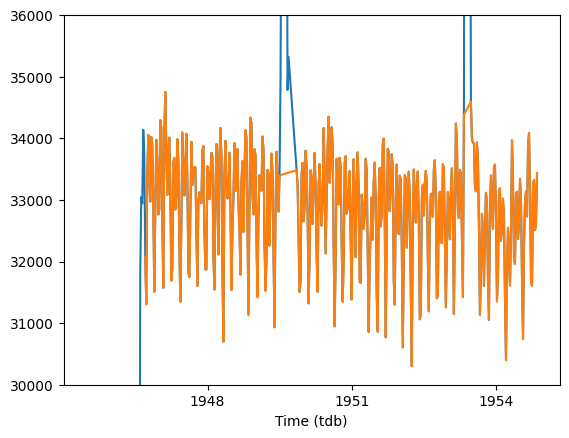

In [5]:
# SOLUTION FOR EXERCISE 2
time_support()
plt.plot(lc.time,lc.flux)
plt.plot(lcc[1].time,lcc[1].flux)
plt.ylim(30000,36000) # Need to zoom in to see the two.

<a id="3"></a>
# 3. Determine if the rotation period returned by `lightkurve` is different when using only one sector's light curve at a time. 

In [6]:
# SOLUTION FOR EXERCISE 3
pg0=lcc[0].to_periodogram()
pg1=lcc[1].to_periodogram()
print(pg0.period_at_max_power.to(u.hr))
print(pg1.period_at_max_power.to(u.hr))
# To 3 significant figures, lightkurve returns the same period (in hours) 
# with either light curve individually or with the two light curves combined.

2.1408393884460524 h
2.1389443295268054 h


<a id="4"></a>
# 4. Try recreating the procedure above to find the rotation period for a fainter (higher magnitude) small body from [Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract) such as Hippodamia. 
What issues do you encounter in this case?

In [7]:
# SOLUTION FOR EXERCISE 5
objname2='Hippodamia'
sector_table2=Tesscut.get_sectors(objectname=objname2, moving_target=True)
print(sector_table2)
# Because there is only one sector, we do not need the loops
# that we did for Eleonora. 
hdulist2 = Tesscut.get_cutouts(objectname=objname2, moving_target=True, size=10)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0003-1-2      3      1   2
tess-s0067-1-2     67      1   2


In [8]:
i=0
hdulist2[i].writeto(objname2+'_'+str(i)+'.fits',overwrite=True)
tpf2 = lk.TessTargetPixelFile(objname2+'_'+str(i)+'.fits')
tpf2.interact()

After scrolling through the cadences, it's clear that Hippodamia passes in front of many stars that significantly impact the flux in the aperture. Since Hippodamia is so much dimmer, the influence on the light curve is much more pronounced than for Eleonora. We can try to use a similar outlier removal, but so many of the flux data points are high, it will likely not work. Generally, differential photometry (comparing images before the asteroid appears and after) is required. Because Hippodamia's period is relatively short, (P=8.9993 hr), we can try to cutout the few days around cadences 365-460 to see if we can find the rotation period from that.

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

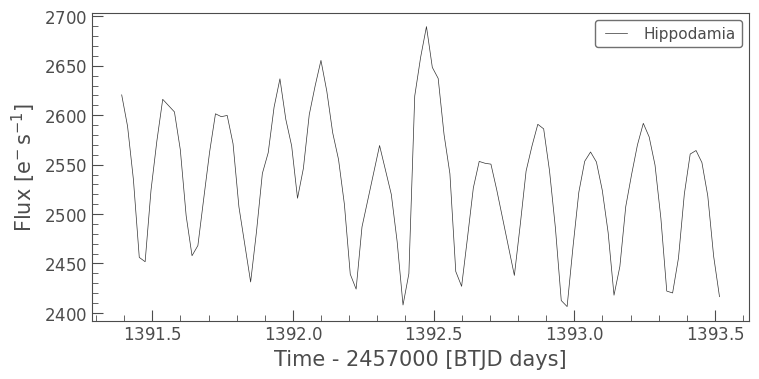

In [9]:
lc2=tpf2.to_lightcurve()
lc2=lc2.truncate(before=365,after=460,column='cadenceno')
lc2.plot()

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


4.473741803782392 h
8.947483607564784 h


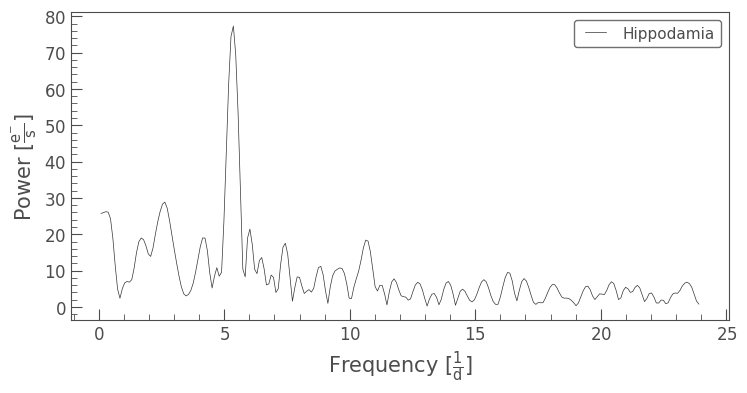

In [10]:
pg2=lc2.to_periodogram()
pg2.plot()
print(pg2.period_at_max_power.to(u.hr))
print(2*pg2.period_at_max_power.to(u.hr))


<Axes: xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

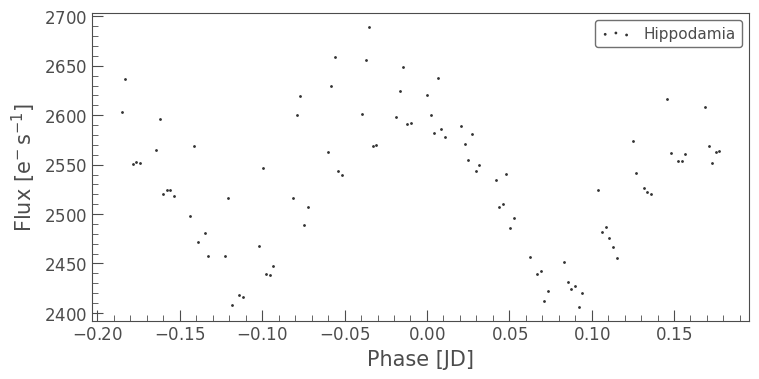

In [11]:
# Again, our result is close to 1/2 times to the accepted period. 
lc2.fold(period=2*pg2.period_at_max_power).scatter()

<a id="5"></a>
# 5. Use [astroquery's Minor Planet Center Queries (MPC)](https://astroquery.readthedocs.io/en/latest/mpc/mpc.html?highlight=mpc#ephemerides) `get_ephemeris` feature to investigate why the median flux for the first sector's observations is lower than for the second sector's observations. 
The times of each cadence are in the light curve's `time` column.

In [12]:
# SOLUTION FOR EXERCISE 6.
from astroquery.mpc import MPC

def print_eph(time):
    # Limit decimals returned
    f = {'decimal':True, 'precision':4}
    
    # Get ephemeris for a given time
    eph = MPC.get_ephemeris('Eleonora', start=time, ra_format=f, dec_format=f)
    
    # Print only relevant columns from the first row
    columns=['Date','RA','Dec','Delta','r','Elongation','Phase','V']
    print(eph[columns][0])
    
# List of the times: first time in first sector, fist time in last sector
t_list = [lcc[0].time[0], lcc[1].time[0]]

for t in t_list:
    print_eph(t)
    print("\n")

          Date             RA     Dec   Delta   r   Elongation Phase  V  
                          deg     deg     AU    AU     deg      deg  mag 
----------------------- ------- ------- ----- ----- ---------- ----- ----
2018-12-15 18:52:08.000 82.2225 -1.5631  1.71 2.635      155.2   9.0 10.0


          Date             RA      Dec   Delta   r   Elongation Phase  V  
                          deg      deg     AU    AU     deg      deg  mag 
----------------------- -------- ------- ----- ----- ---------- ----- ----
2020-04-07 04:51:52.000 213.1404 14.3947 1.672 2.603      152.9  10.1 10.0




In [13]:
# Compare the medians of the two fluxes.
print(np.median(lcc[0].flux))
print(np.median(lcc[1].flux))
print((np.median(lcc[1].flux)-np.median(lcc[0].flux))/np.median(lcc[0].flux))

29377.21484375 electron / s
33036.59375 electron / s
0.12456520646810532


During the second sector, Eleonora was closer to us ("`Delta`") and to the sun ("`r`") than it was in the first. This is likely what caused the median flux to be nearly 12% higher.
***
[Back to top](#Top)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 